## Table of contents

1. [The Problem](#1)  
2. [Possible causes](#2)  
3. [Data](#3)  
4. [Solving the case](#4)  
5. [Summary](#5)

### Validating A/B test results
This case focuses on an improvement to Yammer's core “publisher”—the module at the top of a Yammer feed where users type their messages. To test this feature, the product team ran an A/B test from June 1 through June 30. During this period, some users who logged into Yammer were shown the old version of the publisher (the “control group”), while other other users were shown the new version (the “treatment group”).

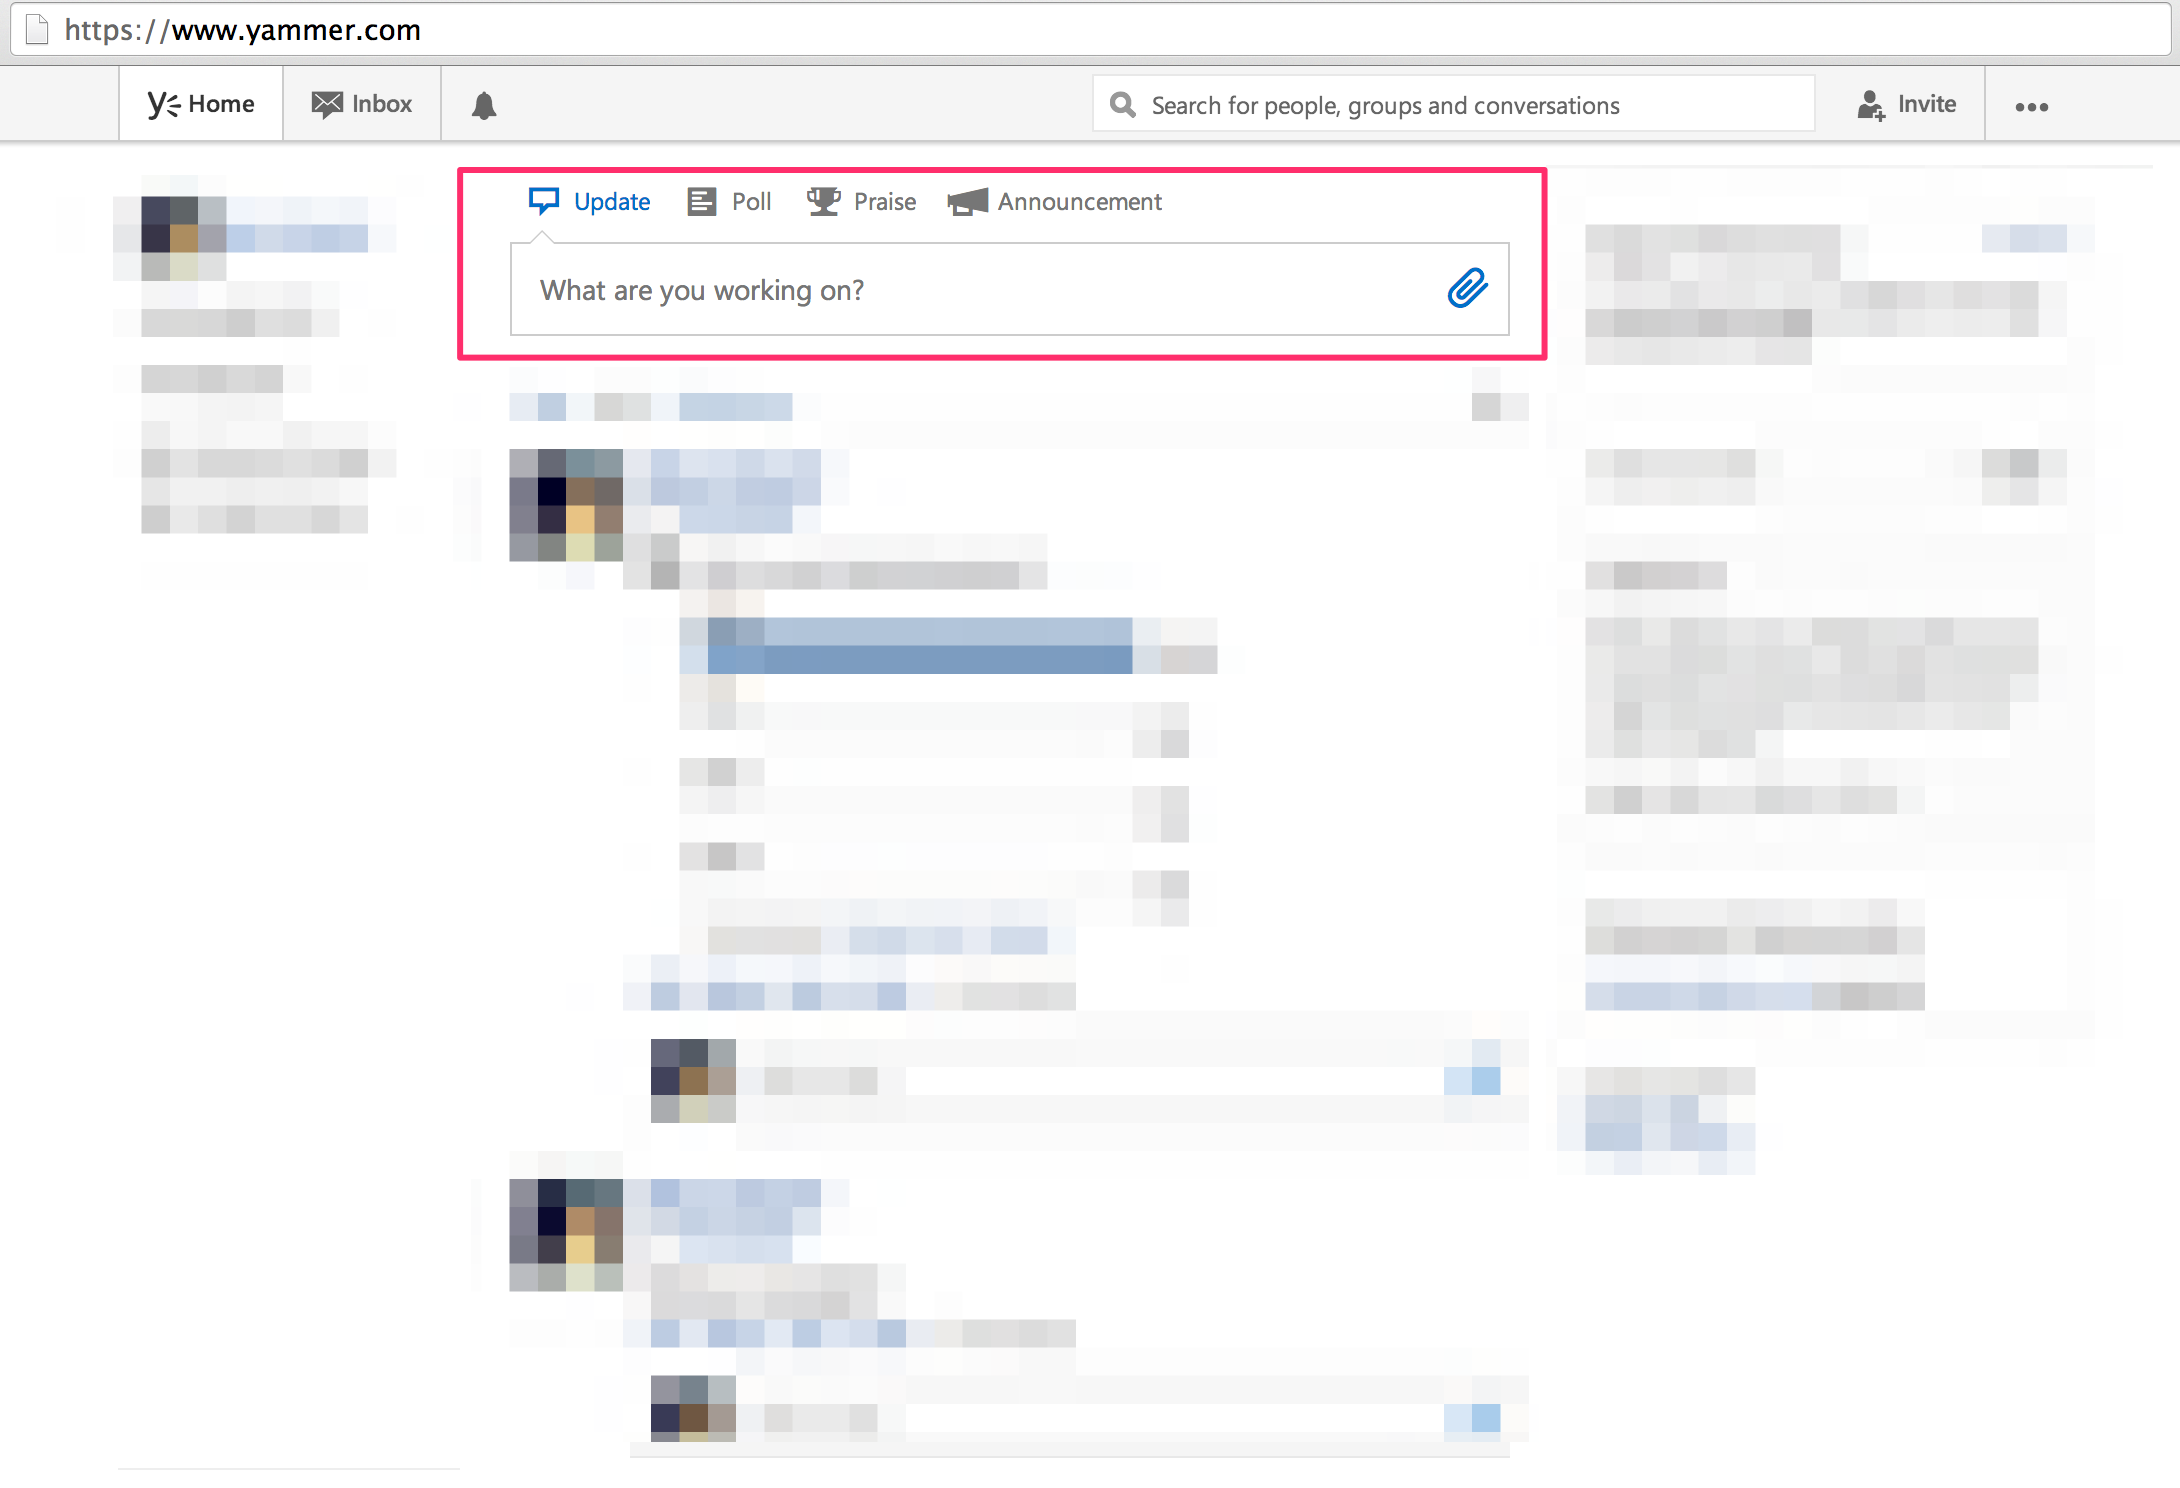

### 1. The problem <a id="1"></a>

* Message posting is 50% higher in the treatment group—a huge increase in posting. 
* Since this figure is quite high, the Analytics team want to check whether this is really the caase or some other factor is leading to such a huge figure.

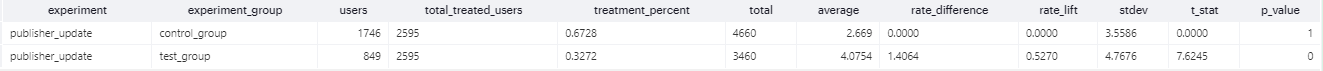

* **users:** The total number of users shown that version of the publisher.
* **total_treated_users:** The number of users who were treated in either group.
* **treatment_percent:** The number of users in that group as a percentage of the total number of treated users.
* **total:** The total number of messages posted by that treatment group.
* **average:** The average number of messages per user in that treatment group (total/users).
* **rate_difference:** The difference in posting rates between treatment groups (group average - control group average).
* **rate_lift:** The percent difference in posting rates between treatment groups ((group average / control group average) - 1).
* **stdev:** The standard deviation of messages posted per user for users in the treatment group. For example, if there were three people in the control group and they posted 1, 4, and 8 messages, this value would be the standard deviation of 1, 4, and 8 (which is 2.9).
* **t_stat:** A test statistic for calculating if average of the treatment group is statistically different from the average of the control group. It is calculated using the averages and standard deviations of the treatment and control groups.
* **p_value:** Used to determine the test's statistical significance.

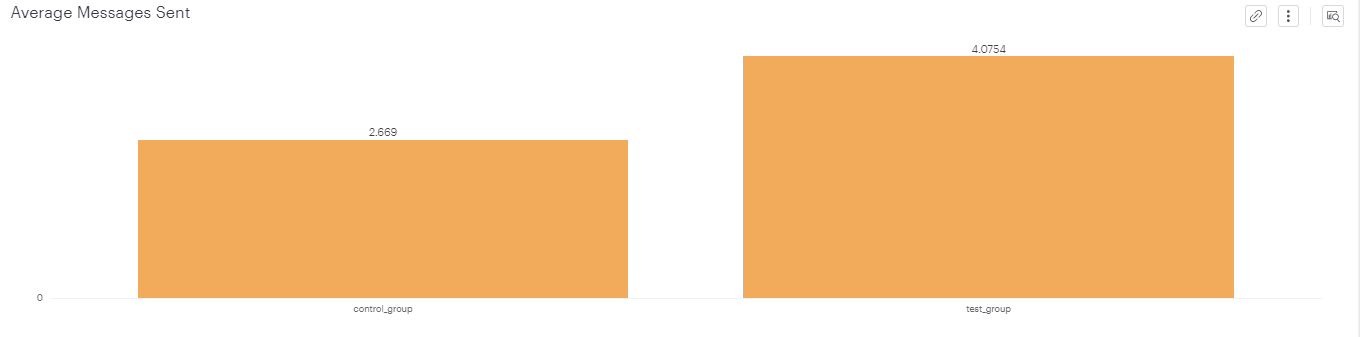

### 2. Possible causes  <a id="2"></a>

* **Metric is incorrect or irrelevant:** Posting rates may not be the correct metric for measuring overall success. It describes how Yammer's customers use the tool, but not necessarily if they're getting value out of it. For example, while a giant "Post New Message" button would probably increase posting rates, it's likely not a great feature for Yammer. Som other metrices may have to be checked as well.
* **The test was calculated incorrectly:** A/B tests are statistical tests. People calculate results using different methods—sometimes that method is incorrect, and sometimes the arithmetic is done poorly.
* **The users were treated incorrectly:** Users are supposed to be assigned to test treatments randomly, but sometimes bugs interfere with this process. If users are treated incorrectly, the experiment may not actually be random.
* **There is an interaction effect:** Experiment treatments could be affecting the product in some other way—for example, it could make some other feature harder to find or create different mobile and desktop experiences. These changes might affect user behavior in unexpected ways, or amplify changes beyond what you would typically expect.

### 3. Data  <a id="3"></a>

#### Table 1: Users
This table includes one row per user, with descriptive information about that user's account.

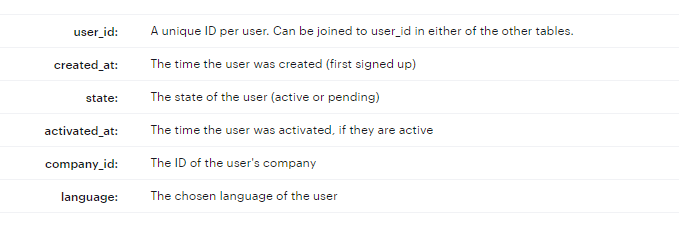

#### Table 2: Events
his table includes one row per event, where an event is an action that a user has taken on Yammer. These events include login events, messaging events, search events, events logged as users progress through a signup funnel, events around received emails.

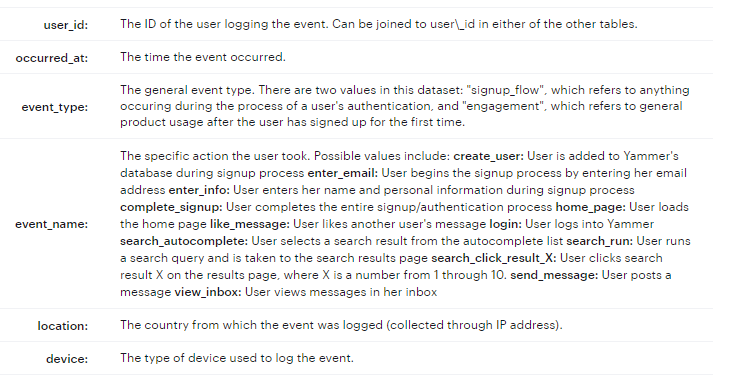

#### Table 3: Experiments

This table shows which groups users are sorted into for experiments. There should be one row per user, per experiment (a user should not be in both the test and control groups in a given experiment).

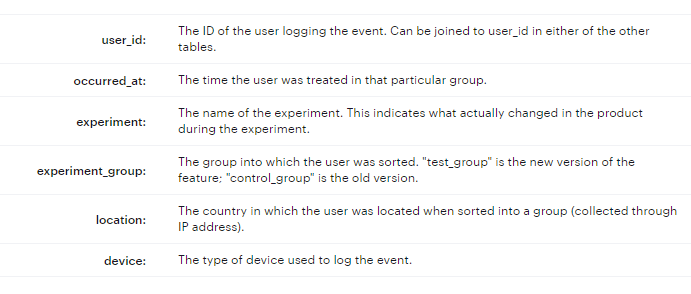

#### Table 4 : Normal Distribution
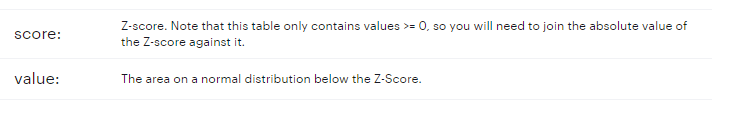

In [3]:
import pandas as pd
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)
df1 = pd.read_csv(r"D:\Documents\Internships\GymCounselor\SQL RKT\users.csv")
df1.to_sql('users', engine)
df2 = pd.read_csv(r"D:\Documents\Internships\GymCounselor\SQL RKT\events.csv")
df2.to_sql('events', engine)
df3 = pd.read_csv(r"D:\Documents\Internships\GymCounselor\SQL RKT\experiments.csv")
df3.to_sql('experiments', engine)
df4 = pd.read_csv(r"D:\Documents\Internships\GymCounselor\SQL RKT\normaltable.csv")
df4.to_sql('normal', engine)

### 4 Solving the case  <a id="4"></a>

#### 4.1 Average number or logins

**Objective:** In addition to the number of messages, it is necessary to evaluate some other metrics as well. 

**Method:** First, information about the experiment group, experiment start date and user id is obtained. For each user id, we calculate the metric which is the number of logins by the specific user after the experiment start date. In the next step, various measures like total number of users in each group, total number of logins, average number of logins, variance and standard deviation of the metric is computed. Next, in order to calculate other measures like the rate_difference, lift and t statistic, we define columns which is the value of the metric in the control group (control_users, control_average etc). Finally, we calculate the rate difference, rate lift, t statistic and p value.

#### ex subquery

Four columns are extracted from the events table : user_id, experiment (publisher_update), experiment_group (treatment or control) and occurred_at.

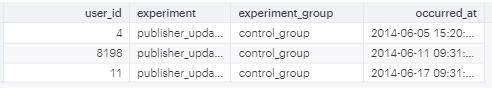

#### a subquery

All the columns from ex subquery are taken and joined to the users table and events table. While joining the columns from ex subquery to the events table, only those rows ae filtered where the user has logged in (apart from the initial signup process). Metric column is added which is the number of times a given user has logged in after the experiment started.

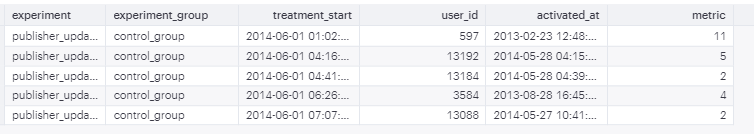

#### b subquery

Data is grouped on the basis of experiment and experiment group and number of users in each group, average value of metric in each group is calculated.

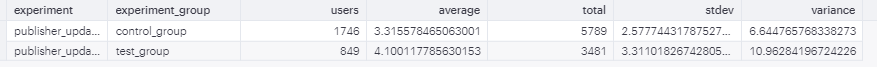

#### c subquery


A few more columns are added to the b subquery : control_users(number of users in teh control group), control_average, control_total, control_variance and control standard deviation.

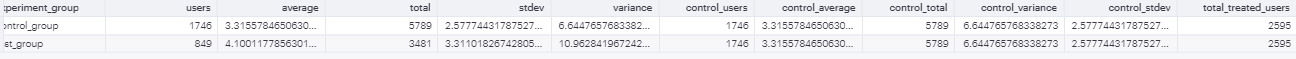

#### Final table

Simple calculations are done on the c subquery to find out the percentage of users in each group, average number of logins in each group, rate difference, rate lift, standard deviation, test statistic and p value.

$ \text{Treatment percent} = \cfrac{\text{users}}{\text{total treated users}}$

$\text{Rate difference} = \text{average number of logins in the experiment group - average number of logins in the control group}$

$\text{Rate lift} = \cfrac{\text{average number of logins in the experiment group- average number of logins in the control group}}{\text{average number of logins in the control group}}$

$\text{Rate lift} = \cfrac{\text{rate difference}}{\text{average number of logins in the control group}}$

$\text{T stat} = \cfrac{\text{rate difference}}{\sqrt{\text{pooled variance}}}$

$\text{Pooled variance} = \cfrac{\text{variance of logins in experiment group}}{\text{number of users in the group}} + \cfrac{\text{variance of logins in control group}}{\text{number of users in the control group}} $

P value is the area under the curve below the test statistic.

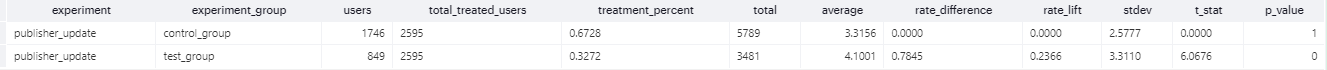

In [ ]:
"""SELECT c.experiment,
       c.experiment_group,
       c.users,
       c.total_treated_users,
       ROUND(c.users/c.total_treated_users,4) AS treatment_percent,
       c.total,
       ROUND(c.average,4)::FLOAT AS average,
       ROUND(c.average - c.control_average,4) AS rate_difference,
       ROUND((c.average - c.control_average)/c.control_average,4) AS rate_lift,
       ROUND(c.stdev,4) AS stdev,
       ROUND((c.average - c.control_average) /
          SQRT((c.variance/c.users) + (c.control_variance/c.control_users))
        ,4) AS t_stat,
       (1 - COALESCE(nd.value,1))*2 AS p_value
  FROM (
SELECT *,
       MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.users ELSE NULL END) OVER () AS control_users,
       MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.average ELSE NULL END) OVER () AS control_average,
       MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.total ELSE NULL END) OVER () AS control_total,
       MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.variance ELSE NULL END) OVER () AS control_variance,
       MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.stdev ELSE NULL END) OVER () AS control_stdev,
       SUM(b.users) OVER () AS total_treated_users
  FROM (
SELECT a.experiment,
       a.experiment_group,
       COUNT(a.user_id) AS users,
       AVG(a.metric) AS average,
       SUM(a.metric) AS total,
       STDDEV(a.metric) AS stdev,
       VARIANCE(a.metric) AS variance
  FROM (
SELECT ex.experiment,
       ex.experiment_group,
       ex.occurred_at AS treatment_start,
       u.user_id,
       u.activated_at,
       COUNT(CASE WHEN e.event_name = 'login' THEN e.user_id ELSE NULL END) AS metric
  FROM (SELECT user_id,
               experiment,
               experiment_group,
               occurred_at
          FROM experiments
         WHERE experiment = 'publisher_update'
       ) ex
  JOIN users u
    ON u.user_id = ex.user_id
  JOIN events e
    ON e.user_id = ex.user_id
   AND e.occurred_at >= ex.occurred_at
   AND e.occurred_at < '2014-07-01'
   AND e.event_type = 'engagement'
 GROUP BY 1,2,3,4,5
       ) a
 GROUP BY 1,2
       ) b
       ) c
  LEFT JOIN benn.normal_distribution nd
    ON nd.score = ABS(ROUND((c.average - c.control_average)/SQRT((c.variance/c.users) + (c.control_variance/c.control_users)),3))"""

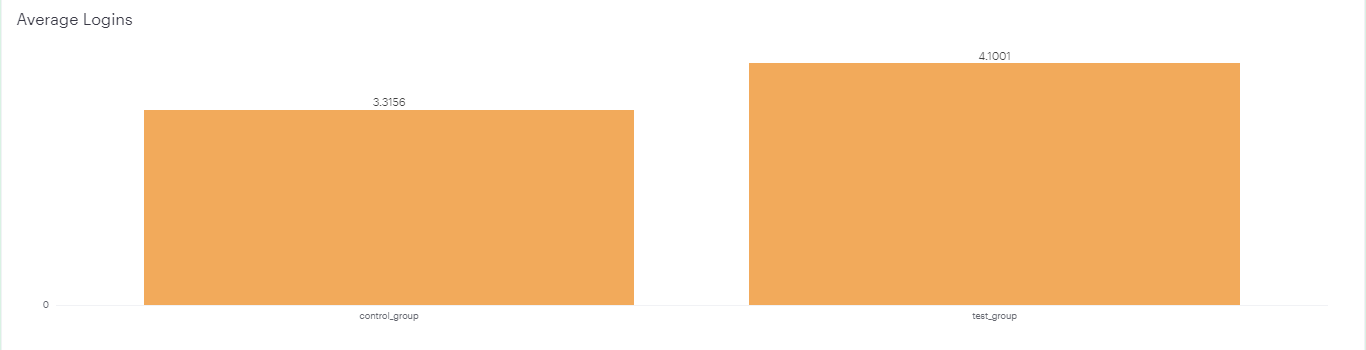

**CONCLUSION**  
The average number of logins per user is up. This suggests that not only are users sending more messages, but they're also signing in to Yammer more.

#### 4.2 Average days engaged

**Objective:** Since the number of messages sent and logins are more in treatment group, it is important to see if the average number of days users engage is also higher for the treatment group. 

**Method:** First, information about the experiment group, experiment start date and user id is obtained. For each user id, we calculate the metric which is the distinct number of days users engaged on yammer after the experiment start date. In the next step, various measures like total number of users in each group, total number of days, average number of days, variance and standard deviation of the metric is computed. Next, in order to calculate other measures like the rate_difference, lift and t statistic, we define columns which is the value of the metric in the control group (control_users, control_average etc). Finally, we calculate the rate difference, rate lift, t statistic and p value.

The only difference between this and the previous code is the metric.


#### a subquery 
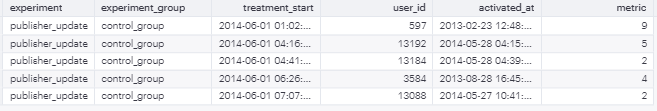

In [ ]:
"""SELECT c.experiment,
       c.experiment_group,
       c.users,
       c.total_treated_users,
       ROUND(c.users/c.total_treated_users,4) AS treatment_percent,
       c.total,
       ROUND(c.average,4)::FLOAT AS average,
       ROUND(c.average - c.control_average,4) AS rate_difference,
       ROUND((c.average - c.control_average)/c.control_average,4) AS rate_lift,
       ROUND(c.stdev,4) AS stdev,
       ROUND((c.average - c.control_average) /
          SQRT((c.variance/c.users) + (c.control_variance/c.control_users))
        ,4) AS t_stat,
       (1 - COALESCE(nd.value,1))*2 AS p_value
  FROM (
SELECT *,
       MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.users ELSE NULL END) OVER () AS control_users,
       MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.average ELSE NULL END) OVER () AS control_average,
       MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.total ELSE NULL END) OVER () AS control_total,
       MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.variance ELSE NULL END) OVER () AS control_variance,
       MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.stdev ELSE NULL END) OVER () AS control_stdev,
       SUM(b.users) OVER () AS total_treated_users
  FROM (
SELECT a.experiment,
       a.experiment_group,
       COUNT(a.user_id) AS users,
       AVG(a.metric) AS average,
       SUM(a.metric) AS total,
       STDDEV(a.metric) AS stdev,
       VARIANCE(a.metric) AS variance
  FROM (
SELECT ex.experiment,
       ex.experiment_group,
       ex.occurred_at AS treatment_start,
       u.user_id,
       u.activated_at,
       COUNT(DISTINCT DATE_TRUNC('day',e.occurred_at)) AS metric
  FROM (SELECT user_id,
               experiment,
               experiment_group,
               occurred_at
          FROM experiments
         WHERE experiment = 'publisher_update'
       ) ex
  JOIN users u
    ON u.user_id = ex.user_id
  JOIN events e
    ON e.user_id = ex.user_id
   AND e.occurred_at >= ex.occurred_at
   AND e.occurred_at < '2014-07-01'
   AND e.event_type = 'engagement'
 GROUP BY 1,2,3,4,5
       ) a
 GROUP BY 1,2
       ) b
       ) c
  LEFT JOIN benn.normal_distribution nd
    ON nd.score = ABS(ROUND((c.average - c.control_average)/SQRT((c.variance/c.users) + (c.control_variance/c.control_users)),3))"""

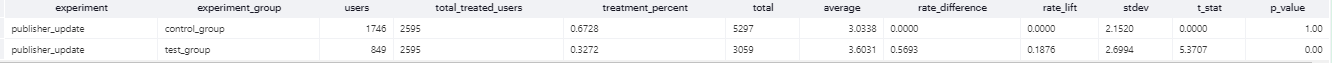

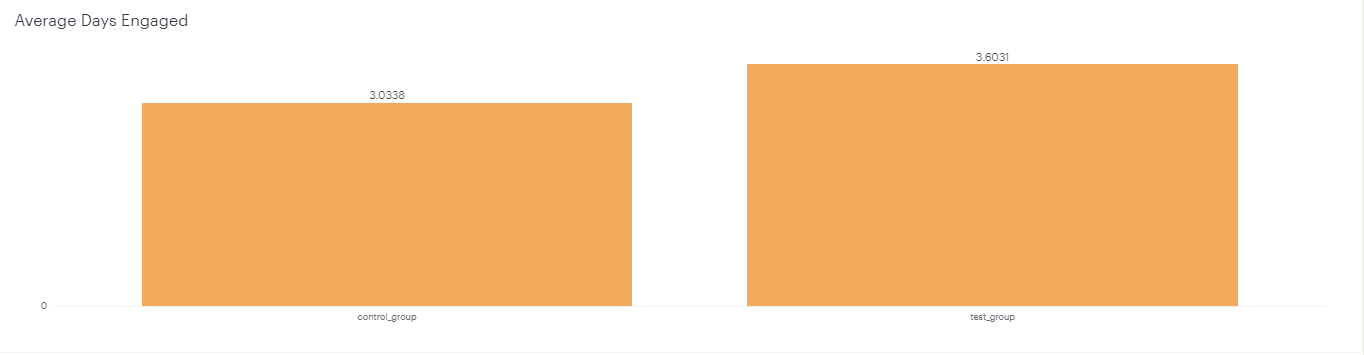

**CONCLUSION**  
The average number of days user engages is also higher for the treatmnet group. If only login was high, it would have meant there is a problem with the site.


#### 4.3 Investigating user treatments 

The test does suffer from a methodological error. The test lumps new users and existing users into the same group, and measures the number of messages they post during the testing window. Users familiar with Yammer might try out a new feature just because it's new, temporarily boosting their overall engagement. For new users, the feature isn't "new," so they're much less likely to use it just because it's different.

**Objective:** To understand how new users are split between the two experimental groups. This can be seen the trend of customers who have activated after the experiment start date in both the groups.

**Method:** Data is grouped on the basis of month and then by using COUNT function, the number of users in each experimental group who have activated their account in that particular month is counted.

In [ ]:
"""SELECT DATE_TRUNC('month',u.activated_at) AS month_activated,
       COUNT(CASE WHEN e.experiment_group = 'control_group' THEN u.user_id ELSE NULL END) AS control_users,
       COUNT(CASE WHEN e.experiment_group = 'test_group' THEN u.user_id ELSE NULL END) AS test_users
  FROM experiments e
  JOIN sers u
    ON u.user_id = e.user_id
 GROUP BY 1
 ORDER BY 1"""

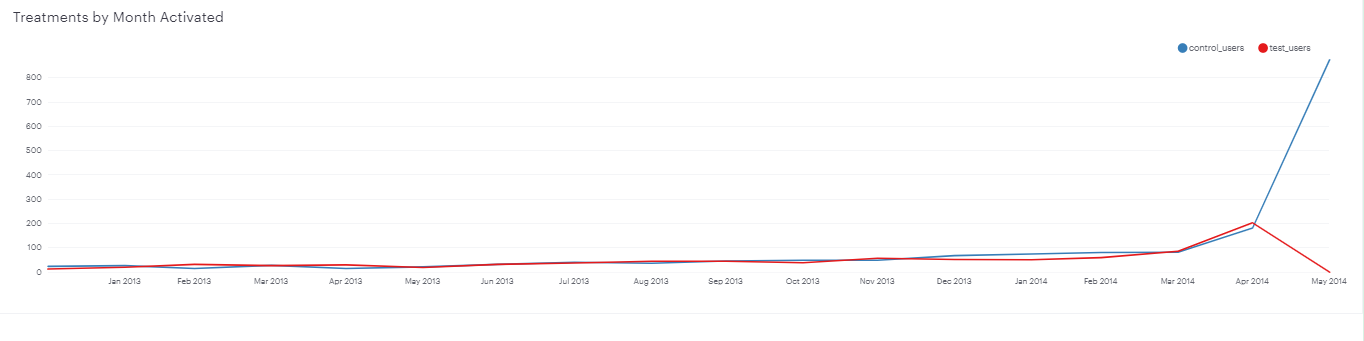

**CONCLUSION**  
All new users were treated in the control group. As most of the users in the control group were new users, they would be expected to post less as the are new to the site and would take time to understand the functionality and working of the site. By including all the new users in one group, this factor is ignored and further analysis is required.

#### 4.4 Average messages sent by existing users

**Objective:** Since all the new users are added in the control group, for further analysis, the new cutomers are ignored and the control and treatment groups are compared. 

**Method:** First, information about the experiment group, experiment start date and user id is obtained. For each user id, we calculate the metric which is the number of messages sent by the user after the experiment start date, data is filtered only for those users who had activated before the start of the experiment. In the next step, various measures like total number of users in each group, total number of logins, average number of logins, variance and standard deviation of the metric is computed. Next, in order to calculate other measures like the rate_difference, lift and t statistic, we define columns which is the value of the metric in the control group (control_users, control_average etc). Finally, we calculate the rate difference, rate lift, t statistic and p value.


#### a subquery
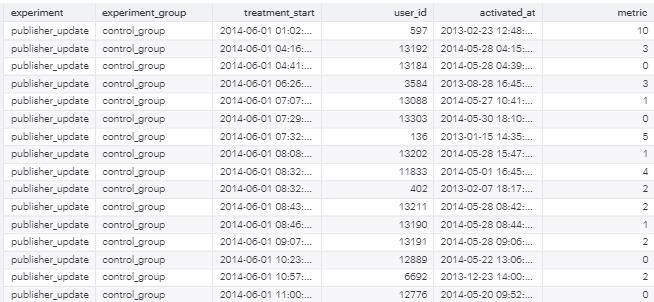

In [ ]:
"""SELECT c.experiment,
       c.experiment_group,
       c.users,
       c.total_treated_users,
       ROUND(c.users/c.total_treated_users,4) AS treatment_percent,
       c.total,
       ROUND(c.average,4)::FLOAT AS average,
       ROUND(c.average - c.control_average,4) AS rate_difference,
       ROUND((c.average - c.control_average)/c.average,4) AS rate_lift,
       ROUND(c.stdev,4) AS stdev,
       ROUND((c.average - c.control_average) /
          SQRT((c.variance/c.users) + (c.control_variance/c.control_users))
        ,4) AS t_stat,
       (1 - COALESCE(nd.value,1))*2 AS p_value
  FROM (
SELECT *,
       MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.users ELSE NULL END) OVER () AS control_users,
       MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.average ELSE NULL END) OVER () AS control_average,
       MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.total ELSE NULL END) OVER () AS control_total,
       MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.variance ELSE NULL END) OVER () AS control_variance,
       MAX(CASE WHEN b.experiment_group = 'control_group' THEN b.stdev ELSE NULL END) OVER () AS control_stdev,
       SUM(b.users) OVER () AS total_treated_users
  FROM (
SELECT a.experiment,
       a.experiment_group,
       COUNT(a.user_id) AS users,
       AVG(a.metric) AS average,
       SUM(a.metric) AS total,
       STDDEV(a.metric) AS stdev,
       VARIANCE(a.metric) AS variance
  FROM (
SELECT ex.experiment,
       ex.experiment_group,
       ex.occurred_at AS treatment_start,
       u.user_id,
       u.activated_at,
       COUNT(CASE WHEN e.event_name = 'send_message' THEN e.user_id ELSE NULL END) AS metric
  FROM (SELECT user_id,
               experiment,
               experiment_group,
               occurred_at
          FROM experiments
         WHERE experiment = 'publisher_update'
       ) ex
  JOIN users u
    ON u.user_id = ex.user_id
   AND u.activated_at < '2014-06-01'
  JOIN events e
    ON e.user_id = ex.user_id
   AND e.occurred_at >= ex.occurred_at
   AND e.occurred_at <= '2014-07-01'
   AND e.event_type = 'engagement'
 GROUP BY 1,2,3,4,5
       ) a
 GROUP BY 1,2
       ) b
       ) c
  LEFT JOIN benn.normal_distribution nd
    ON nd.score = ABS(ROUND((c.average - c.control_average)/SQRT((c.variance/c.users) + (c.control_variance/c.control_users)),3))"""

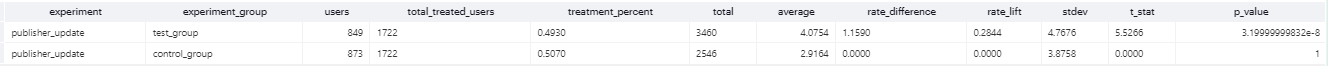

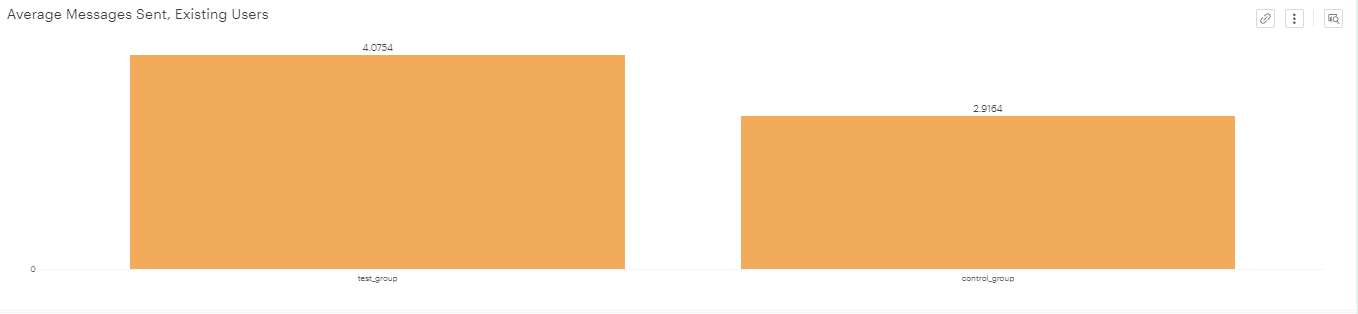

### 5. Summary  <a id="5"></a>

Overall, the test results are still strong. But given the above result, we should validate that change across different cohorts and fix the logging error that treated all new users in one group.